<a href="https://colab.research.google.com/github/harshhrawte/ML/blob/main/8_classification_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔄 LOADING AND PREPROCESSING DATA...
✅ Dataset unzipped successfully
✅ Dataset loaded successfully with shape: (200020, 17)
🔽 Using subset of data: (40004, 17)

📊 DATASET OVERVIEW:
Original columns: ['Patient ID', 'Heart Rate', 'Respiratory Rate', 'Timestamp', 'Body Temperature', 'Oxygen Saturation', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI', 'Derived_MAP', 'Risk Category']

Columns after dropping: ['Heart Rate', 'Respiratory Rate', 'Body Temperature', 'Oxygen Saturation', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI', 'Derived_MAP', 'Risk Category']

🔍 Missing values check:
Heart Rate                  0
Respiratory Rate            0
Body Temperature            0
Oxygen Saturation           0
Systolic Blood Pressure     0
Diastolic Blood Pressure    0
Age            

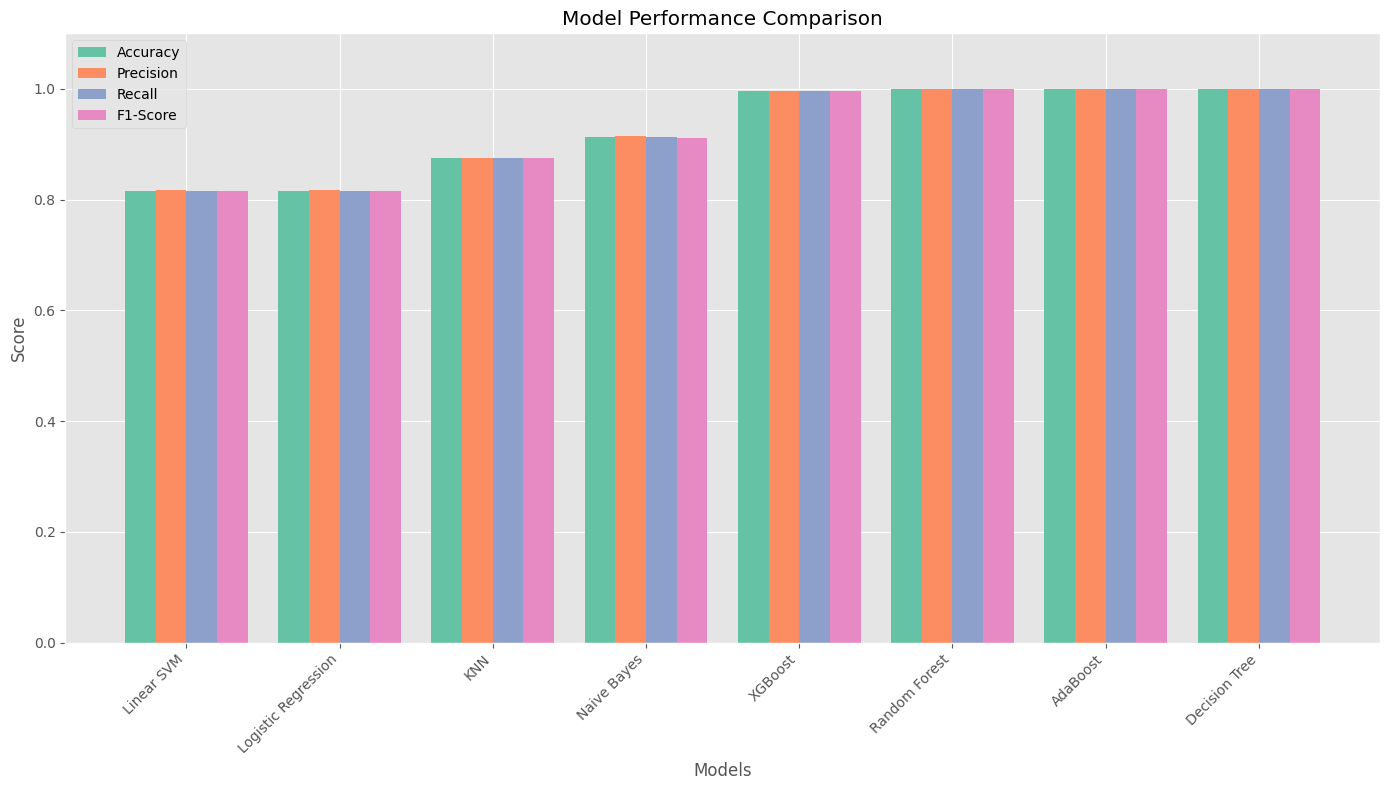

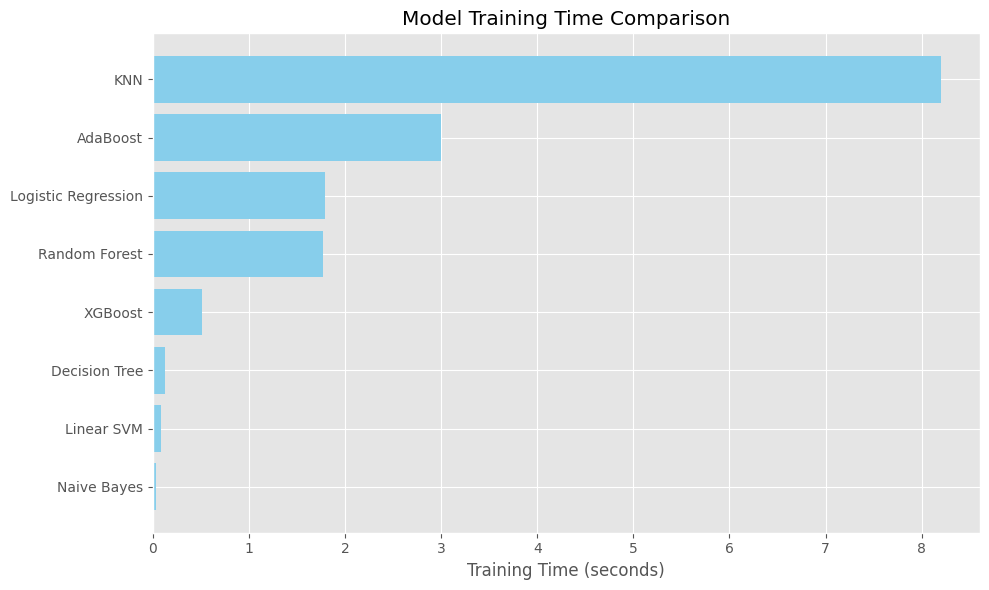

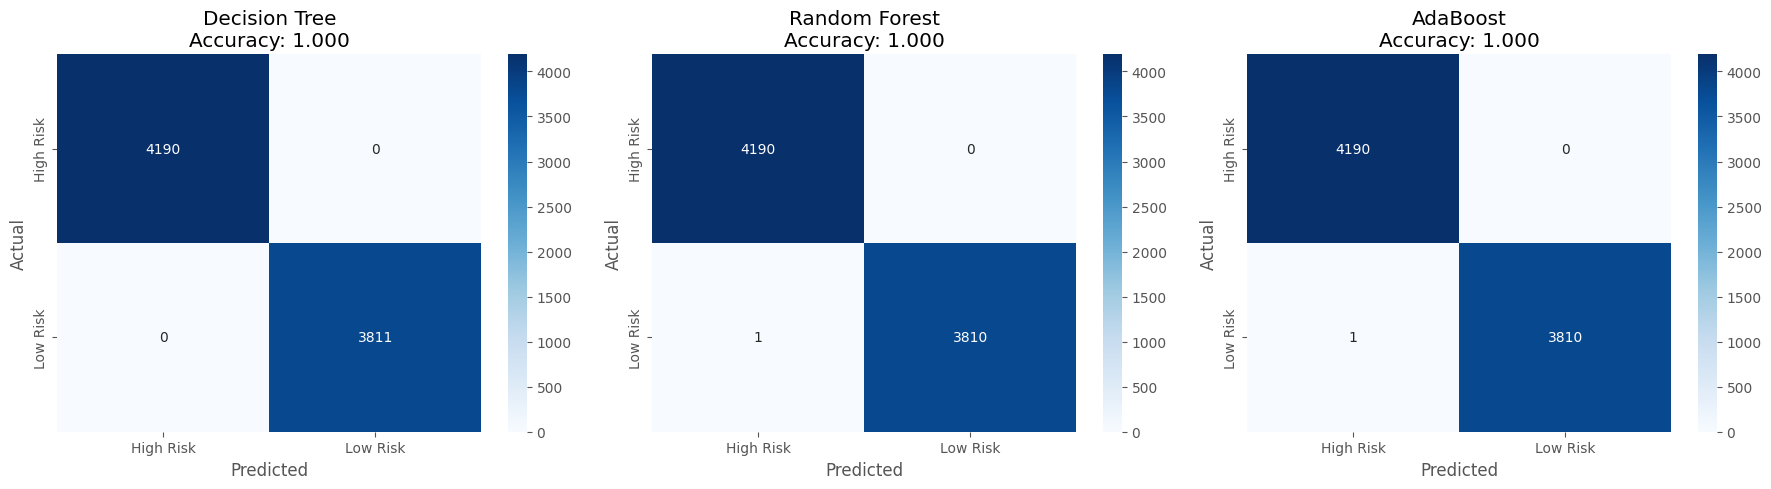

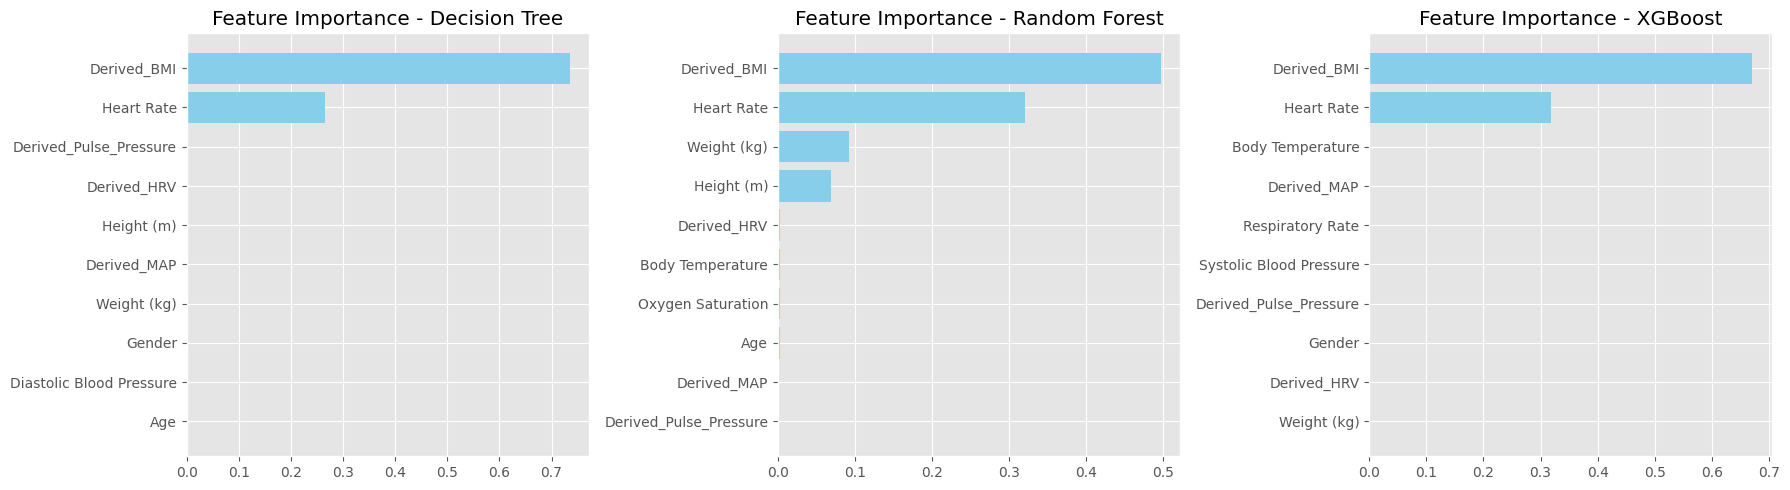


🏆 FINAL MODEL RANKING BY ACCURACY
+----+---------------------+------------+-------------+----------+------------+-----------+---------------------+--------+
|    | Algorithm           |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-ROC |   Training Time (s) |   Rank |
+====+=====================+============+=============+==========+============+===========+=====================+========+
|  2 | Decision Tree       |     1      |      1      |   1      |     1      |    1      |              0.1327 |      1 |
+----+---------------------+------------+-------------+----------+------------+-----------+---------------------+--------+
|  3 | Random Forest       |     0.9999 |      0.9999 |   0.9999 |     0.9999 |    1      |              1.7699 |      2 |
+----+---------------------+------------+-------------+----------+------------+-----------+---------------------+--------+
|  6 | AdaBoost            |     0.9999 |      0.9999 |   0.9999 |     0.9999 |    0.9998 |             

In [1]:
# Human Vital Signs Risk Classification - Optimized Analysis
# 8 Classification Algorithms with Performance Comparison

# Install required packages
!pip install xgboost tabulate seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

# Constants
SAMPLE_FRACTION = 0.2  # Using 20% of data for faster processing
RANDOM_STATE = 42

print("🔄 LOADING AND PREPROCESSING DATA...")

# Load and unzip the dataset
try:
    with zipfile.ZipFile('/content/human_vital_signs_dataset_2024.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("✅ Dataset unzipped successfully")

    # Load the CSV file
    df = pd.read_csv('/content/human_vital_signs_dataset_2024.csv')
    print(f"✅ Dataset loaded successfully with shape: {df.shape}")

    # Sample the data to make it faster
    df = df.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)
    print(f"🔽 Using subset of data: {df.shape}")

except Exception as e:
    print(f"⚠ Error loading dataset: {e}")
    raise

# Data preprocessing
print("\n📊 DATASET OVERVIEW:")
print(f"Original columns: {list(df.columns)}")

# Drop unnecessary columns
cols_to_drop = ['Patient ID', 'Timestamp']
df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)
print(f"\nColumns after dropping: {list(df.columns)}")

# Encode categorical variables
le = LabelEncoder()
if 'Gender' in df.columns:
    df['Gender'] = le.fit_transform(df['Gender'])
df['Risk Category'] = le.fit_transform(df['Risk Category'])

# Check for missing values
print("\n🔍 Missing values check:")
print(df.isnull().sum())

# Remove rows with missing values if any
df = df.dropna()
print(f"\nFinal dataset shape after cleaning: {df.shape}")

# Separate features and target
X = df.drop('Risk Category', axis=1)
y = df['Risk Category']

print(f"\n🎯 Target distribution:")
print(y.value_counts(normalize=True))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📦 Data split:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Define optimized models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=500, n_jobs=-1),
    'Linear SVM': LinearSVC(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE, n_estimators=50),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, n_estimators=100,
                                n_jobs=-1, eval_metric='logloss')
}

print("\n🤖 TRAINING MODELS AND CALCULATING METRICS...")

# Train models and collect metrics
results = []
all_predictions = {}
training_times = {}

for name, model in models.items():
    print(f"\n⚙ Training {name}...")

    try:
        start_time = pd.Timestamp.now()

        # Choose appropriate data (scaled vs unscaled)
        if name in ['Logistic Regression', 'Linear SVM', 'KNN', 'Naive Bayes']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_pred_proba = np.zeros(len(y_test))  # Dummy for LinearSVC
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        try:
            auc_roc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc_roc = 0.0

        # Calculate training time
        end_time = pd.Timestamp.now()
        training_time = (end_time - start_time).total_seconds()

        # Store results
        results.append({
            'Algorithm': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_roc,
            'Training Time (s)': training_time
        })

        all_predictions[name] = y_pred
        training_times[name] = training_time

        print(f"✅ Completed in {training_time:.2f} seconds")

    except Exception as e:
        print(f"⚠ Error with {name}: {str(e)}")
        continue

# Create performance dataframe
performance_df = pd.DataFrame(results)

print("\n" + "="*80)
print("📊 COMPREHENSIVE PERFORMANCE MATRIX")
print("="*80)
print(tabulate(performance_df.sort_values('Accuracy', ascending=False),
      headers='keys', tablefmt='grid'))

# Visualization 1: Model Performance Comparison
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
performance_df = performance_df.sort_values('Accuracy')

x = np.arange(len(performance_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, performance_df[metric], width=width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, performance_df['Algorithm'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Visualization 2: Training Time Comparison
plt.figure(figsize=(10, 6))
performance_df = performance_df.sort_values('Training Time (s)')
plt.barh(performance_df['Algorithm'], performance_df['Training Time (s)'], color='skyblue')
plt.xlabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')
plt.tight_layout()
plt.show()

# Visualization 3: Confusion Matrices for Top 3 Models
performance_df = performance_df.sort_values('Accuracy', ascending=False)
top_models = performance_df.head(3)['Algorithm'].values

plt.figure(figsize=(18, 5))
for i, name in enumerate(top_models, 1):
    plt.subplot(1, 3, i)
    cm = confusion_matrix(y_test, all_predictions[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name}\nAccuracy: {performance_df[performance_df["Algorithm"]==name]["Accuracy"].values[0]:.3f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Visualization 4: Feature Importance
tree_models = [m for m in ['Decision Tree', 'Random Forest', 'XGBoost'] if m in models]
if tree_models:
    plt.figure(figsize=(18, 5))
    for i, name in enumerate(tree_models, 1):
        plt.subplot(1, len(tree_models), i)
        model = models[name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[-10:]  # Top 10 features
            plt.title(f'Feature Importance - {name}')
            plt.barh(range(len(indices)), importances[indices], color='skyblue')
            plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.tight_layout()
    plt.show()

# Final Results
print("\n" + "="*80)
print("🏆 FINAL MODEL RANKING BY ACCURACY")
print("="*80)
performance_df = performance_df.sort_values('Accuracy', ascending=False)
performance_df['Rank'] = range(1, len(performance_df)+1)
print(tabulate(performance_df.round(4), headers='keys', tablefmt='grid'))

# Best model info
best_model = performance_df.iloc[0]
print("\n" + "="*80)
print(f"🎉 BEST PERFORMING MODEL: {best_model['Algorithm']}")
print("="*80)
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print(f"Training Time: {best_model['Training Time (s)']:.2f} seconds")

print("\n✅ ANALYSIS COMPLETE! All performance metrics and visualizations generated.")